In [1]:
# From WoFSCast
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

from wofscast import icosahedral_mesh, model_utils, square_mesh
from wofscast import grid_mesh_connectivity 
from wofscast.square_mesh import _ChildVerticesBuilder, TriangularMesh, merge_meshes

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import cartopy.crs as ccrs
from glob import glob
import math 

def _get_max_and_mean_edge_distance(mesh):
  senders, receivers = square_mesh.faces_to_edges(mesh.faces)
  edge_distances = np.linalg.norm(
      mesh.vertices[senders] - mesh.vertices[receivers], axis=-1)
  return edge_distances.max(), edge_distances.mean() 

def plot_mesh(ax, mesh, level, mesh_x=None, mesh_y=None, color='r', markersize=2, lw=0.5):
    
    if mesh_x is None: 
        mesh_x, mesh_y = mesh.vertices[:, 0], mesh.vertices[:, 1]
    
    triangulation = mtri.Triangulation(mesh_x, mesh_y, triangles=mesh.faces)
    ax.triplot(triangulation, 'go-', markersize=markersize, markerfacecolor='green',
               markeredgecolor='green', 
               lw=lw, color=color, alpha=0.9, zorder=15)
    #ax.set_title(f'Triangular Mesh Grid')
    return ax

# Modified plot_mesh function
def plot_mesh_from_point(ax, mesh, level, node_idx, color='r', markersize=2):
    vertices = mesh.vertices
    faces = mesh.faces

    # Create the triangulation
    triangulation = mtri.Triangulation(vertices[:, 0], vertices[:, 1], triangles=faces)
    
    # Plot the entire mesh
    #ax.triplot(triangulation, 'go-', markersize=markersize, lw=0.5, color='b')
    
    # Find and plot points connected to the specific node
    connected_points = set()
    for face in faces:
        if node_idx in face:
            connected_points.update(face)
    
    connected_points = list(connected_points)
    
    ax.plot(vertices[connected_points, 0], vertices[connected_points, 1], 'ro', markersize=markersize)
    ax.set_title(f'Triangular Mesh Grid')
    return ax


## Creating a heirarchial structured mesh on a square domain

In [6]:
# Specification of the multimesh.
mesh_size=5
N=150
tiling= (2,2)

if tiling==1: 
    meshes = square_mesh.get_hierarchy_of_tiled_triangular_meshes(tiling, 
                                                                  N, 
                                                                  mesh_size, legacy_mesh=True)
    merged_meshes = merge_tiled_meshes(meshes)
    
else:
    meshes = (
        square_mesh.get_hierarchy_of_triangular_meshes(
            splits=mesh_size, domain_size=N, tiling=tiling, legacy_mesh=True))
    
    merged_meshes = square_mesh.merge_meshes(meshes)

finest_mesh = meshes[-1]

#grid_lat = dataset['lat'].values
#grid_lon = dataset['lon'].values

#mesh_nodes_lon, mesh_nodes_lat = square_mesh.get_mesh_coords(finest_mesh, grid_lat, grid_lon)

max_dist, mean_dist = _get_max_and_mean_edge_distance(finest_mesh)

print(f'Max distance on Finest Mesh: {max_dist*3:.1f}km')
print(f'Mean distance on Finest Mesh: {mean_dist*3:.1f}km')

Correcting the bi-direction mesh edges
Max distance on Finest Mesh: 13.7km
Mean distance on Finest Mesh: 11.0km


In [3]:
mean_dist * 3

11.043602228164673

### Plot the Meshes (with States and Counties shown underneath)

NameError: name 'grid_lon' is not defined

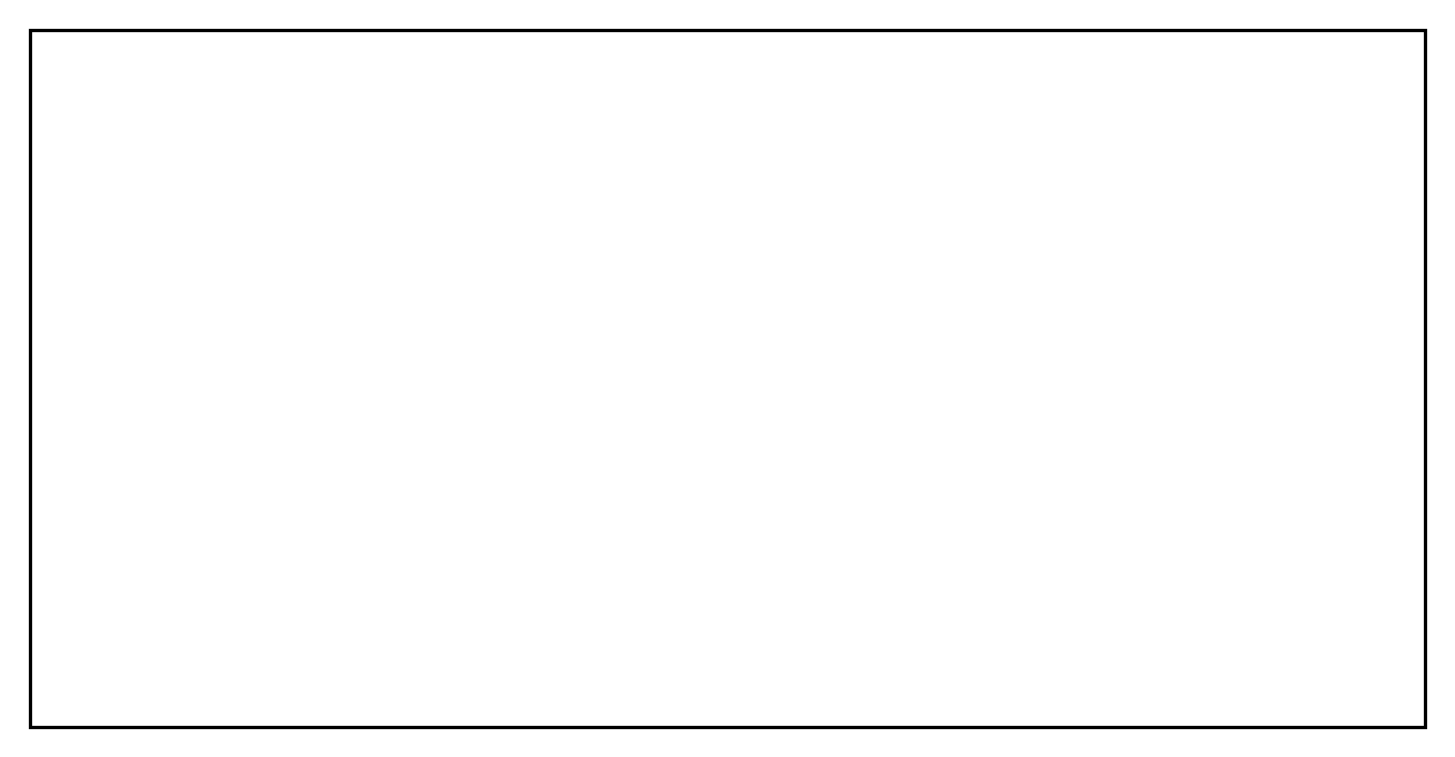

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#fig, ax = plt.subplots(dpi=300, figsize=(4,4))

fig, ax = plt.subplots(dpi=300, figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})


i = -1 
#plot_mesh(ax, meshes[i], level=i, color ='k', markersize=0.1)

# Calculate extent (min and max lat/lon) to limit the plot area
dx = 1.0
extent = [np.min(grid_lon)-dx, np.max(grid_lon)+dx, np.min(grid_lat)-dx, np.max(grid_lat)+dx]


# Add state boundaries
states = cfeature.NaturalEarthFeature(category='cultural', scale='10m', 
                                      facecolor='none', name='admin_1_states_provinces')
ax.add_feature(states, edgecolor='red', linewidth=0.5)

# Add county boundaries
counties = cfeature.NaturalEarthFeature(category='cultural', scale='10m',
                                        facecolor='none', name='admin_2_counties')
ax.add_feature(counties, edgecolor='lightgray', linewidth=0.2)

# Set the extent of the map to the region of interest
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Plot the mesh
plot_mesh(ax, meshes[i], mesh_x= mesh_nodes_lon, mesh_y=mesh_nodes_lat, 
          level=i, color='k', markersize=1.0, lw=0.25)

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')

ax.annotate('Oklahoma', xy=(0.7, 0.1), xycoords='axes fraction', fontsize=7, color='lightgray')
ax.annotate('Texas', xy=(0.4, 0.1), xycoords='axes fraction', fontsize=7, color='lightgray')
ax.annotate('New\nMexico', xy=(0.05, 0.1), xycoords='axes fraction', fontsize=7, color='lightgray')
ax.annotate('Colorado', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=7, color='lightgray')
ax.annotate('Nebraska', xy=(0.5, 0.95), xycoords='axes fraction', fontsize=7, color='lightgray')
ax.annotate('Kansas', xy=(0.875, 0.5), xycoords='axes fraction', fontsize=7, color='lightgray')

## Plot the Merged Meshes

Correcting the bi-direction mesh edges
Correcting the bi-direction mesh edges
Correcting the bi-direction mesh edges
Correcting the bi-direction mesh edges
Correcting the bi-direction mesh edges
Correcting the bi-direction mesh edges


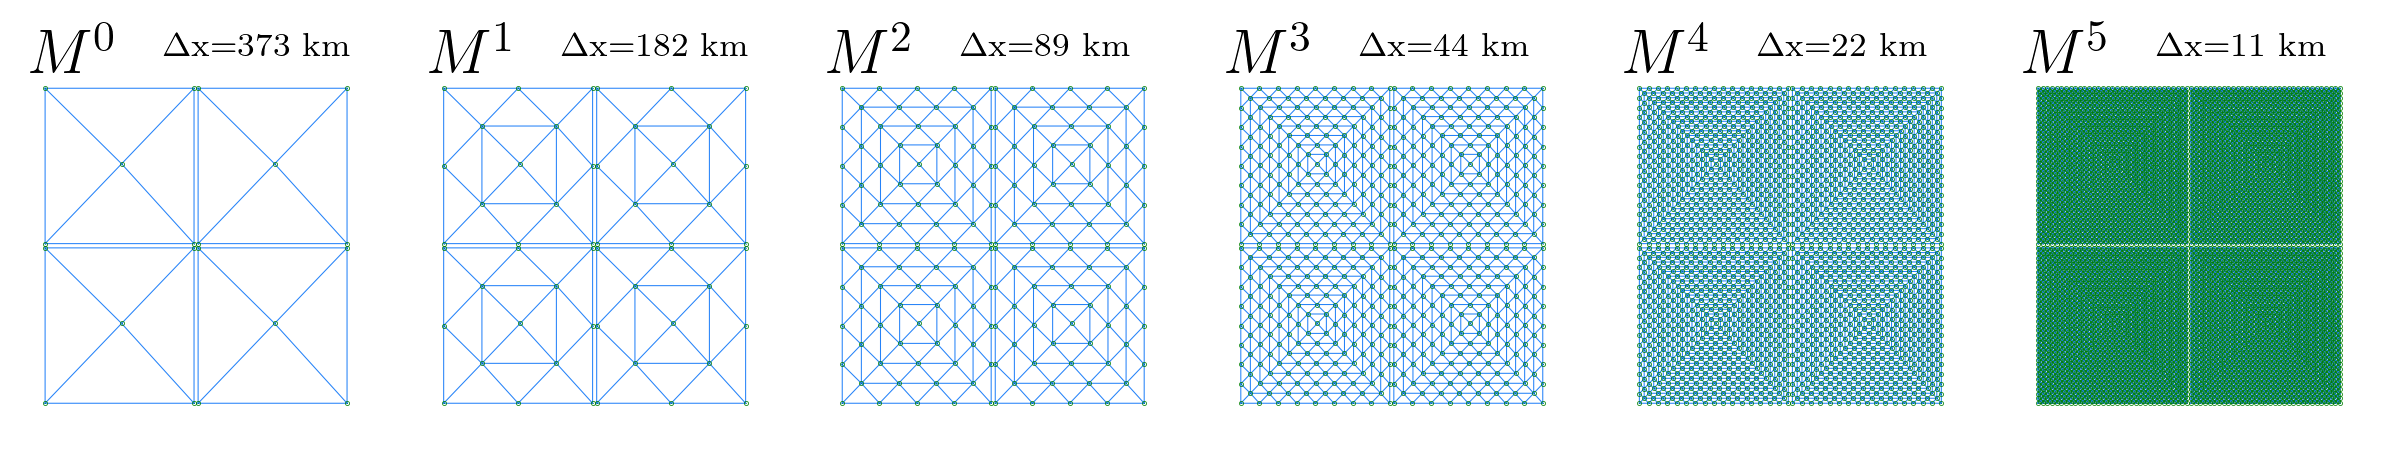

In [8]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, axes = plt.subplots(dpi=300, figsize=(10,1.5), ncols=len(meshes))

colors = ["xkcd:sky blue", "xkcd:sky blue", "xkcd:azure", 
          "xkcd:dodger blue", "xkcd:deep sky blue", "xkcd:dark"]

for i in range(len(meshes)):
    plot_mesh(axes[i], meshes[i], level=i, color = "xkcd:deep sky blue", markersize=0.2, lw=0.25)
    axes[i].annotate(rf'$M^{i}$', xy=(0,1), xycoords='axes fraction', fontsize=15)
    axes[i].axis('off')
    max_dist, mean_dist = _get_max_and_mean_edge_distance(meshes[i])
    # Multiply by the 3 km grid spacing
    axes[i].annotate(rf'$\Delta$x={int(mean_dist*3)} km', xy=(0.4, 1.05), xycoords='axes fraction', fontsize=8)
    

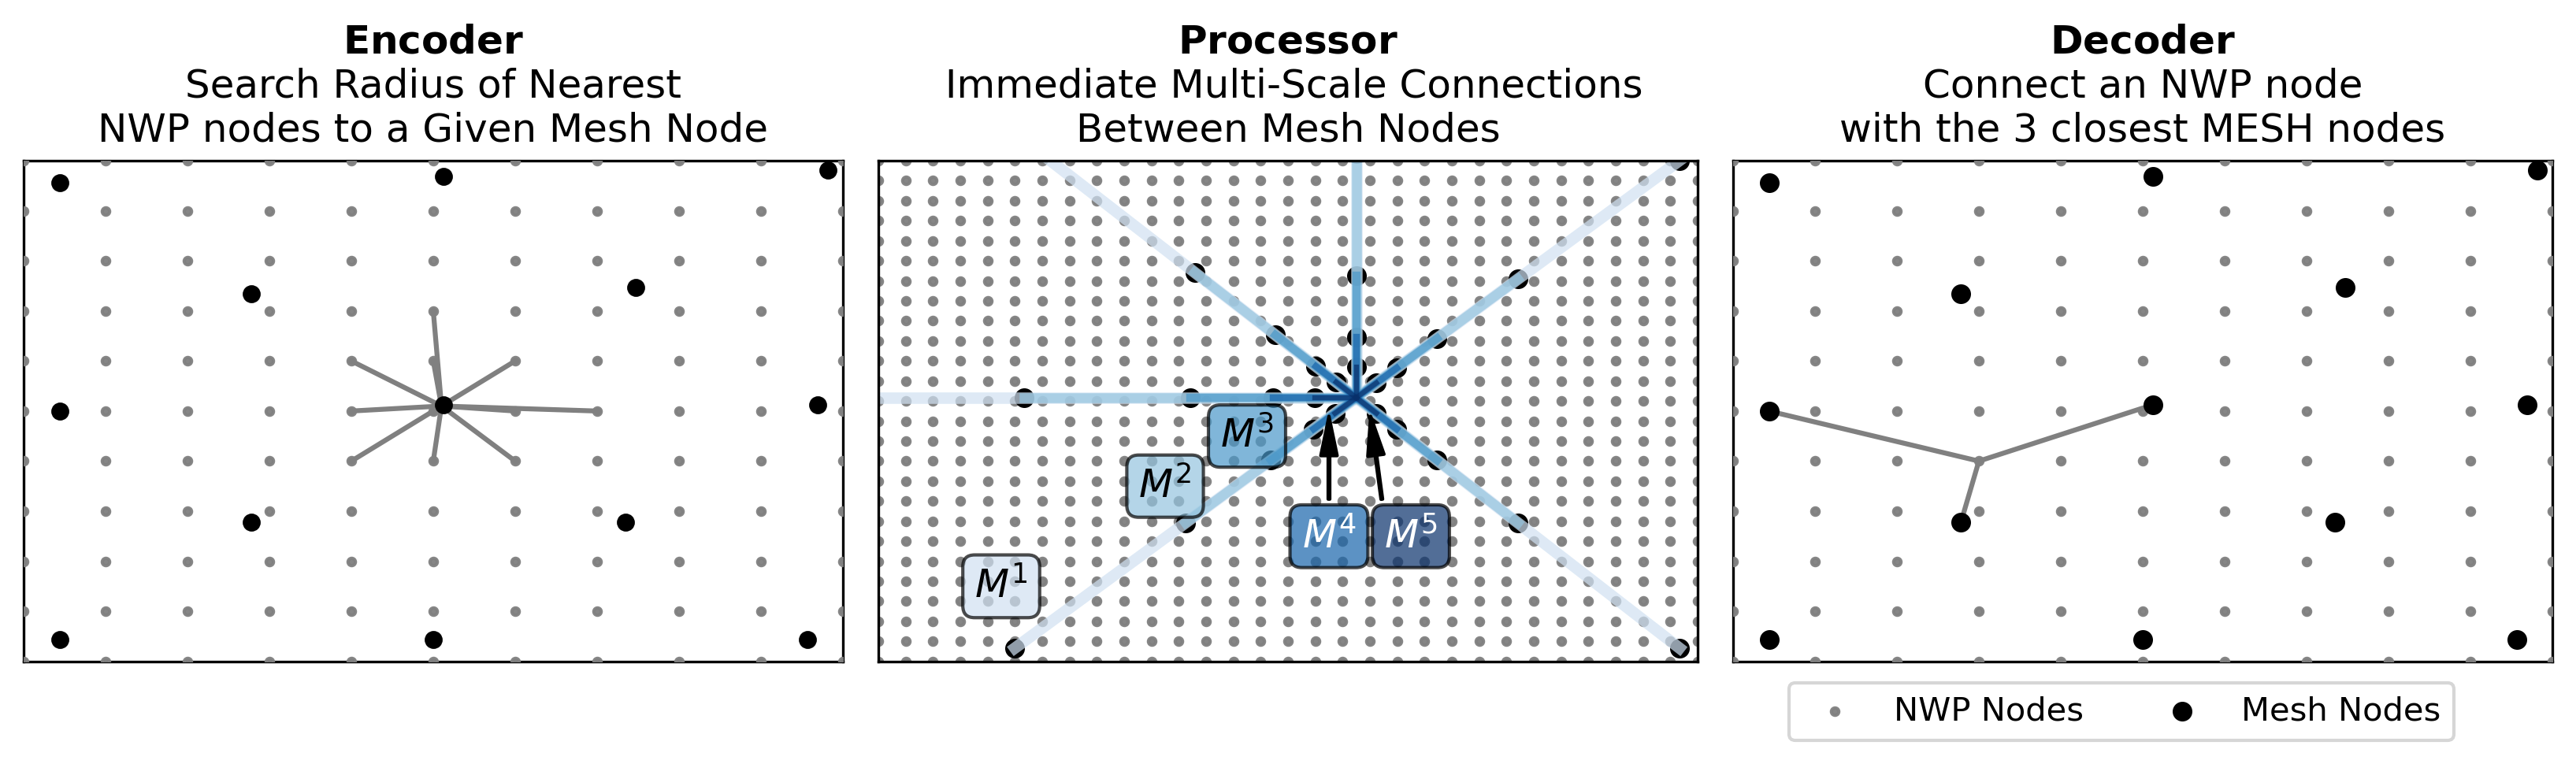

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from matplotlib.colors import ListedColormap

# Set up the NWP grid and mesh points
n_points = 150
nwp_x, nwp_y = np.meshgrid(np.arange(n_points+1), np.arange(n_points+1))

fig, axes = plt.subplots(ncols=3, dpi=300, figsize=(11,3))

# Define the point of interest (POI) on the mesh
poi = (30.1, 30.1)

mesh_size=5
these_meshes = square_mesh.get_hierarchy_of_triangular_meshes(
            splits=mesh_size, domain_size=n_points+5, tiling=tiling)

merged_mesh = square_mesh.merge_meshes(these_meshes)

mesh_x, mesh_y = meshes[-1].vertices[:,0], meshes[-1].vertices[:,1]

#poi = mesh_x[50], mesh_y[50]

size = 5 

# Panel 1: Connect nearest NWP points to the POI on the mesh grid
axes[0].scatter(nwp_x, nwp_y, s=size, label='NWP Points', zorder=15, color='gray', alpha=0.95)
axes[0].scatter(mesh_x, mesh_y, s=size+15, label='Mesh Points', zorder=15, color='black')

# Calculate distances from all NWP points to the POI
distances_nwp_to_poi = distance.cdist(np.array([poi]), np.c_[nwp_x.ravel(), nwp_y.ravel()])

# Get the indices of the closest NWP points
closest_nwp_indices = np.argsort(distances_nwp_to_poi[0])[:11]  # Adjust the number of closest points as needed

# Draw arrows from the closest NWP points to the POI
for idx in closest_nwp_indices:
    nwp_point = (nwp_x.ravel()[idx], nwp_y.ravel()[idx])
    axes[0].plot([nwp_point[0], poi[0]], [nwp_point[1], poi[1]], color='gray')

axes[0].set_title(r"$\bf{Encoder}$"+"\nSearch Radius of Nearest\nNWP nodes to a Given Mesh Node")

# Panel 2: Connect all nearest mesh points to the POI on the mesh grid
axes[1].scatter(nwp_x[::3, ::3], nwp_y[::3, ::3], s=size, 
                label='NWP Points', color='gray',alpha =0.95)
#axes[1].scatter(mesh_x, mesh_y, s=size+10, label='Mesh Points', zorder=15)

# Define the mesh node of interest
mesh_poi =6  # example node index


# Get the colormap
cmap = plt.get_cmap('Blues')
# Number of colors you want to extract
n_colors = 6
# Extract colors
colors = cmap(np.linspace(0, 1, n_colors))

# For low to high resolution mesh. 
for i, mesh in enumerate(these_meshes):
    mesh_senders, mesh_receivers = square_mesh.faces_to_edges(mesh.faces)
    # Find all receiver nodes connected to the mesh_poi
    connected_indices = np.where(mesh_senders == mesh_poi)[0]

    # Draw arrows from the mesh_poi to its receiver nodes
    for idx in connected_indices:
        receiver_node = mesh_receivers[idx]
        receiver_point = (mesh_x[receiver_node], mesh_y[receiver_node])
        
        axes[1].scatter(mesh_x[receiver_node], mesh_y[receiver_node], color='black', s=25)
        axes[1].plot([mesh_x[mesh_poi], receiver_point[0]], [mesh_y[mesh_poi], receiver_point[1]], 
                     color=colors[i], lw=4-(i*0.5), alpha=0.7) #zorder=20-i)
    

axes[1].set_title(r"$\bf{Processor}$"+"\n Immediate Multi-Scale Connections\nBetween Mesh Nodes")

# Panel 3: Pick a random NWP point and connect it to the nearest mesh point
axes[2].scatter(nwp_x, nwp_y, s=size, label='NWP Nodes', zorder=15, color='gray', alpha=0.95)
axes[2].scatter(mesh_x, mesh_y, s=size+20, label='Mesh Nodes', zorder=16, color='black')

random_nwp_point = (3+25, 4+25)

# Calculate distances from the random NWP point to all mesh points
distances_nwp_to_mesh = distance.cdist(np.array([random_nwp_point]), np.c_[mesh_x, mesh_y])

# Get the indices of the closest mesh points
closest_mesh_indices = np.argsort(distances_nwp_to_mesh[0])[:3]  # Adjust the number of closest points as needed

# Draw arrows from the closest mesh points to the POI
for idx in closest_mesh_indices:
    mesh_point = (mesh_x[idx], mesh_y[idx])
    axes[2].plot([mesh_point[0], random_nwp_point[0]], [mesh_point[1], random_nwp_point[1]], color='gray')

axes[2].set_title(r"$\bf{Decoder}$"+"\nConnect an NWP node\nwith the 3 closest MESH nodes")

# Adjust axes settings: keep axes on, but remove tick marks
for ax in axes:
    ax.axis('on')
    ax.set_xticks([])
    ax.set_yticks([])

for i, ax in enumerate(axes):
    if i == 1:
        #pass
        ax.set_ylim([0, 75])
        ax.set_xlim([60, 150])
    else:
        ax.set_ylim([25, 35])
        ax.set_xlim([25, 35])
    
plt.tight_layout()

axes[2].legend(bbox_to_anchor=(0.9, -0.1), ncols=2)

# Add annotations with bounding boxes and arrows where needed
annotations = [
    (0, (0.15, 0.15), None),
    (1, (0.35, 0.35), None),
    (2, (0.45, 0.45), None),
    (3, (0.55, 0.5), (0.55, 0.25)),
    (4, (0.6, 0.5), (0.65, 0.25))
]

for i, xy, xytext in annotations:
    arrowprops = dict(facecolor='k', shrink=0.05, width=0.5, headwidth=5) if xytext else None
    txt_c = 'k' if i < 3 else 'white'
    
    axes[1].annotate(
        rf'$M^{i+1}$',
        xy=xy,  # Position of the annotation in axes fraction
        xytext=xytext,
        xycoords='axes fraction',
        textcoords='axes fraction',
        fontsize=12,
        color=txt_c,
        ha='center',
        va='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[i+1], alpha=0.7),
        arrowprops=arrowprops
    )






In [8]:
import numpy as np

mesh_senders, mesh_receivers = square_mesh.faces_to_edges(merged_mesh.faces)

# Count the occurrences of each node in mesh_receivers
receiver_counts = np.bincount(mesh_receivers)

# Find the index (mesh node) with the maximum count
max_receiver_node = np.argmax(receiver_counts)
max_receiver_count = receiver_counts[max_receiver_node]

print(f"The mesh node receiving the most inputs is {max_receiver_node}, with {max_receiver_count} inputs.")


The mesh node receiving the most inputs is 5, with 30 inputs.


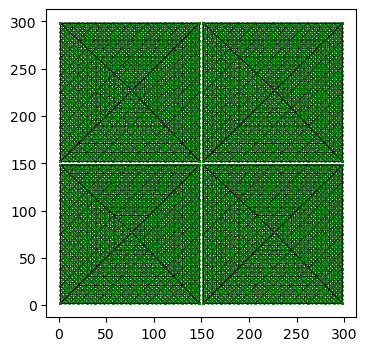

In [7]:
import matplotlib.animation as animation

fig, ax = plt.subplots(dpi=100, figsize=(4,4))
colors = ['r', 'b', 'g', 'k', 'purple', 'orange']

s = 1

def update(level):
    #ax.clear()
    plot_mesh(ax, meshes[level], level, color='k', markersize=s)

anim = animation.FuncAnimation(fig, update, frames=len(meshes), repeat=True)

# To display the animation in a Jupyter notebook
from IPython.display import HTML
HTML(anim.to_jshtml())

# Optionally, to save the animation
#anim.save("mesh.gif", writer="pillow", fps=0.5)  


In [10]:
these_meshes=[]

for i, mesh in enumerate(meshes):
    print(f'Refinement {i}')
    # Step 4: Create the Mesh Data Structure
    vertices = mesh.vertices  # The vertices are just the points on the grid
    faces = mesh.faces  # The faces are defined by the Delaunay triangulation

    print(f'Num of Nodes: {len(vertices)}\nNumb of Faces: {len(faces)}')
    # Calculate and print the number of unique edges
    edges = set()
    for face in faces:
        # Ensure each edge is stored such that the first vertex index is less than the second
        for i in range(3):
            v1, v2 = sorted([face[i], face[(i+1) % 3]])  # Create sorted tuples of vertex indices
            edges.add((v1, v2))
    print(f'Num of Edges: {len(edges)*2}\n')
    
    these_meshes.append(mesh)
    
    combined_mesh = square_mesh.merge_meshes(these_meshes) 
    
    vertices = combined_mesh.vertices  # The vertices are just the points on the grid
    faces = combined_mesh.faces  # The faces are defined by the Delaunay triangulation


    # Calculate and print the number of unique edges
    edges = set()
    for face in faces:
        # Ensure each edge is stored such that the first vertex index is less than the second
        for i in range(3):
            v1, v2 = sorted([face[i], face[(i+1) % 3]])  # Create sorted tuples of vertex indices
            edges.add((v1, v2))
    print(f'Num of MultiLevel Edges: {len(edges)*2}\n')

Refinement 0
Num of Nodes: 5
Numb of Faces: 4
Num of Edges: 16

Num of MultiLevel Edges: 16

Refinement 1
Num of Nodes: 13
Numb of Faces: 16
Num of Edges: 56

Num of MultiLevel Edges: 72

Refinement 2
Num of Nodes: 41
Numb of Faces: 64
Num of Edges: 208

Num of MultiLevel Edges: 280

Refinement 3
Num of Nodes: 145
Numb of Faces: 256
Num of Edges: 800

Num of MultiLevel Edges: 1080

Refinement 4
Num of Nodes: 545
Numb of Faces: 1024
Num of Edges: 3136

Num of MultiLevel Edges: 4216

Refinement 5
Num of Nodes: 2113
Numb of Faces: 4096
Num of Edges: 12416

Num of MultiLevel Edges: 16632



## Connecting NWP nodes to Mesh nodes

In [12]:
# Convert latitudes and longitudes to Cartesian coordinates
grid_positions = square_mesh.get_grid_positions(N)
mesh_positions = meshes[-1].vertices
  
# Plot mesh vertices
fig, ax = plt.subplots(dpi=300, figsize=(8,8))
ax.scatter(mesh_positions[:, 0], mesh_positions[:, 1], color='blue', label='Mesh Nodes', alpha=0.9)
ax.scatter(grid_positions[:, 0], grid_positions[:, 1], color='gray', s=2.0, label='Grid Nodes')

# Add the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(0.25, 1.025), ncols=2)

# Annotate the distance between two points
# Define the two points for the annotation
point1 = mesh_positions[0]  # Replace with the actual indices or coordinates
point2 = mesh_positions[1]

ax.annotate('$\\delta x = 11 \\, km$', 
            xy=(point1[0], point1[1]-0.01), 
            xycoords = '', 
            xytext=((point1[0] + point2[0]) // 2, (point1[1] + point2[1]) // 2),
            textcoords='offset points', arrowprops=dict(arrowstyle='<->', color='black'), ha='center')

# Remove x-ticks and y-ticks
ax.set_xticks([])
ax.set_yticks([])


ax.set_ylim([0,25])
ax.set_xlim([0,25])



(0.0, 25.0)

Error in callback <function _draw_all_if_interactive at 0x150a92b9b5b0> (for post_execute), with arguments args (),kwargs {}:


ValueError: '' is not a valid coordinate

ValueError: '' is not a valid coordinate

<Figure size 2400x2400 with 1 Axes>

In [13]:
# Obtain the query radius in absolute units for the unit-sphere for the
# grid2mesh model, by rescaling the `radius_query_fraction_edge_length`.
fraction = 0.99
query_radius = math.ceil(_get_max_and_mean_edge_distance(finest_mesh)[0]*fraction)

In [23]:
query_radius=5

In [24]:
# Radius is interpreted in the 3 km grid spacing distance. 
grid_indices, mesh_indices = square_mesh.radius_query_indices(N, finest_mesh, radius=query_radius)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_connectivity_3d(grid_size, mesh, grid_indices, mesh_indices):
    fig = plt.figure(dpi=300, figsize=(16, 16))
    ax = fig.add_subplot(111, projection='3d')

    # Generate grid points
    lon, lat = np.meshgrid(np.arange(0, grid_size), np.arange(0, grid_size))
    z = np.zeros_like(lon)  # Adding a third dimension for the grid points

    # Highlight connections
    for g_idx, m_idx in zip(grid_indices, mesh_indices):
        grid_point = [lon.flatten()[g_idx], lat.flatten()[g_idx], z.flatten()[g_idx]]
        mesh_node = mesh.vertices[m_idx]
        ax.plot([grid_point[0], mesh_node[0]], 
                [grid_point[1], mesh_node[1]], 
                [0, 3], 'r-', lw=0.5)

    # Plot grid points
    ax.scatter(lon.flatten(), lat.flatten(), z.flatten(), 
               color='gray', s=0.3, label='Grid Points', alpha=0.9)
    
    # Plot mesh vertices
    ax.scatter(mesh.vertices[:, 0], mesh.vertices[:, 1], np.ones(mesh.vertices[:,1].shape)+3, 
               color='blue', s=0.3, label='Mesh Nodes', alpha=0.9)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Height')  # Assuming height or another relevant third dimension

    ax.legend(loc='upper right')
    
    ax.set_ylim([0,5])
    ax.set_xlim([0,5])
    ax.set_zlim([0,10])  # Example: setting z limits
    
    return ax 

# Example usage
#plot_connectivity_3d(N, finest_mesh, grid_indices, mesh_indices)


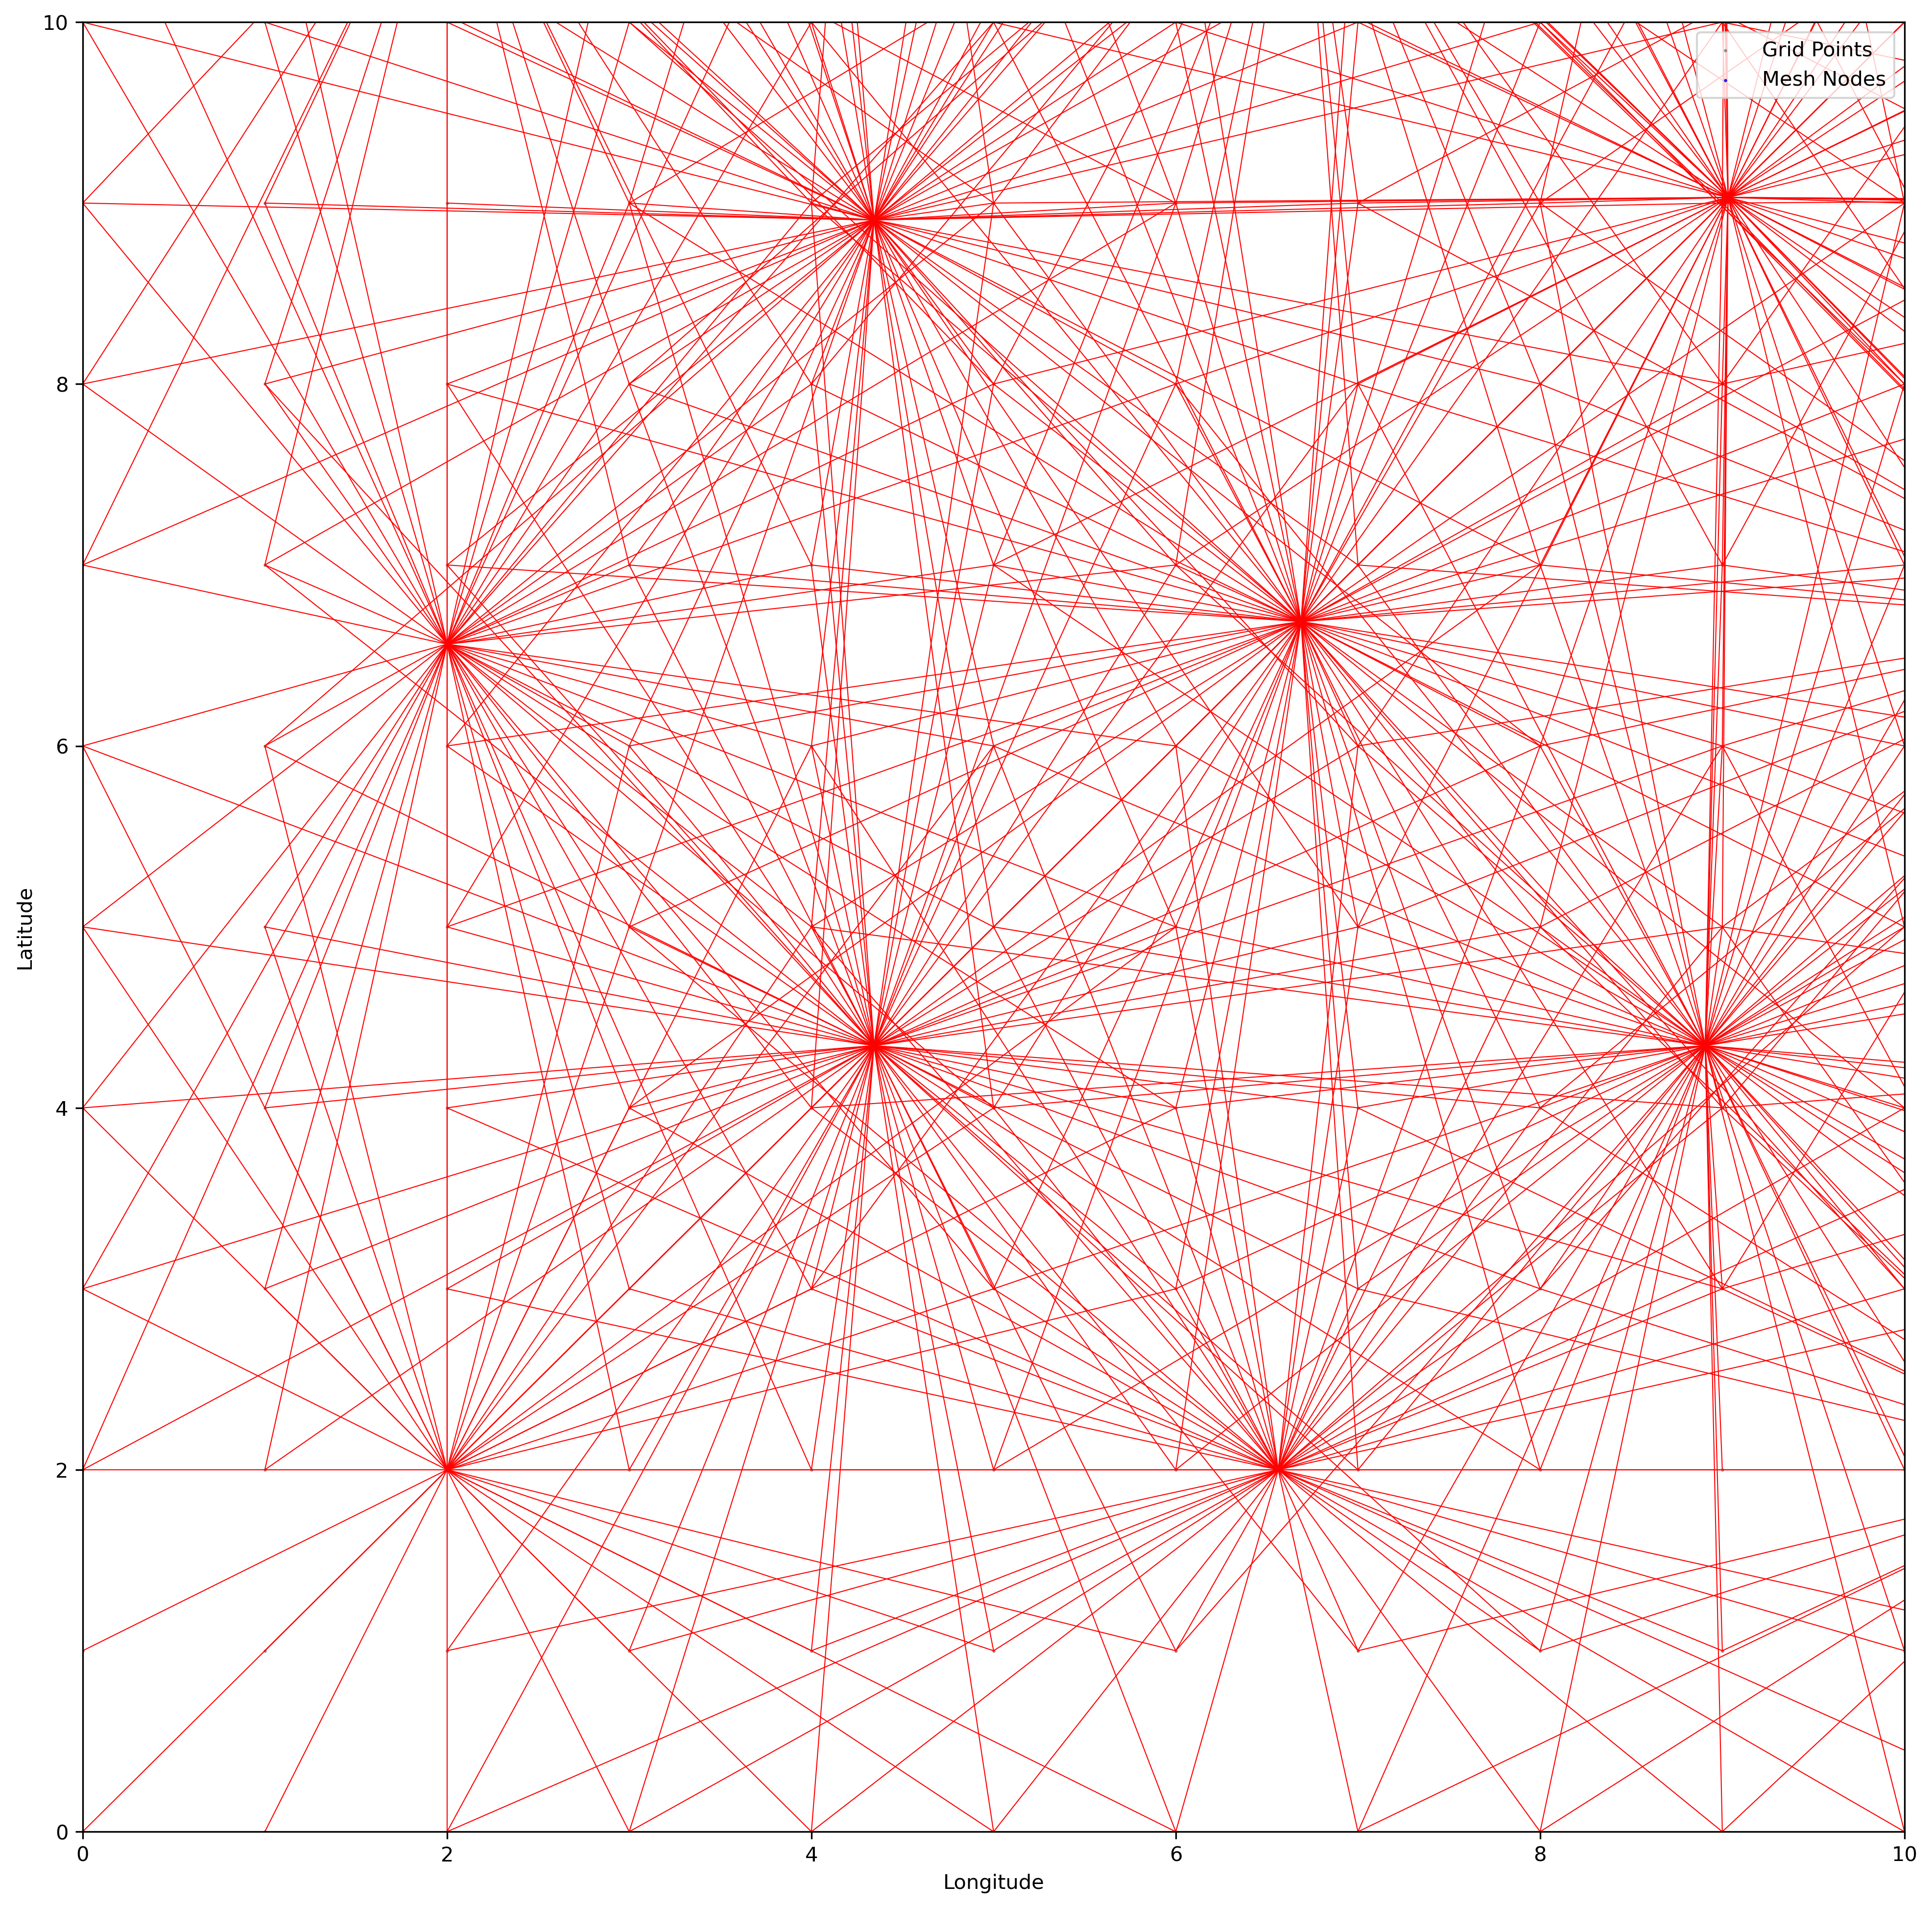

In [26]:
# Plot how the grid nodes connect to a single mesh node.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_connectivity(grid_size, mesh, grid_indices, mesh_indices):
    fig, ax = plt.subplots(dpi=300, figsize=(16,16))

    # Generate grid points and plot
    lon, lat = np.meshgrid(np.arange(0,grid_size), np.arange(0,grid_size))

    # Highlight connections
    for g_idx, m_idx in zip(grid_indices, mesh_indices):
        grid_point = [lon.flatten()[g_idx], lat.flatten()[g_idx]]
        mesh_node = mesh.vertices[m_idx]
        ax.plot([grid_point[0], mesh_node[0]], [grid_point[1], mesh_node[1]], 'r-', lw=0.5)

    ax.scatter(lon.flatten(), lat.flatten(), color='gray', 
               s=0.3, label='Grid Points', alpha=0.9)   
        
    # Plot mesh vertices
    ax.scatter(mesh.vertices[:, 0], mesh.vertices[:, 1], s=0.3, 
               color='blue', label='Mesh Nodes', alpha=0.9)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend(loc='upper right')
    
    ax.set(xlim=(0,10), ylim=(0,10))
    
    plt.show()
    
plot_connectivity(N, finest_mesh, grid_indices, mesh_indices)

#plot_connectivity(300, finest_mesh, grid_indices, mesh_indices)

In [6]:
grid_lat.min(), grid_lat.max()

(30.088554, 38.26361)

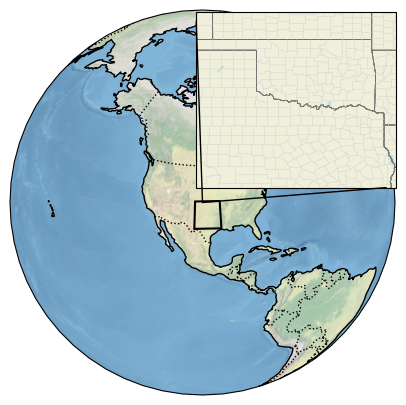

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches

def plot_main_and_inset():
    # Create the main map with the Orthographic projection
    fig = plt.figure(figsize=(5, 5))
    ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-100, 
                                                                    central_latitude=38))
    ax_main.set_global()
    
    # Add natural features to the main map
    ax_main.add_feature(cfeature.LAND)
    ax_main.add_feature(cfeature.OCEAN)
    ax_main.add_feature(cfeature.COASTLINE)
    ax_main.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Zoomed-in region coordinates (approximate)
    lon_min, lon_max = -102.808014, -93.47449
    lat_min, lat_max = 30.088554, 38.26361
    
    # Plot the main map
    ax_main.stock_img()
    
    # Define the location of the inset map (bounding box)
    inset_axes = fig.add_axes([0.5, 0.5, 0.4, 0.4], projection=ccrs.PlateCarree())
    inset_axes.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    inset_axes.add_feature(cfeature.LAND)
    inset_axes.add_feature(cfeature.COASTLINE)
    inset_axes.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Example contour or other features in the inset map
    # You can add specific data here, like contours, markers, etc.
    inset_axes.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
    inset_axes.add_feature(cfeature.LAKES, color='lightblue', alpha=0.5)
    
    
    # Add state boundaries
    states = cfeature.NaturalEarthFeature(category='cultural', scale='10m', 
                                      facecolor='none', name='admin_1_states_provinces')
    inset_axes.add_feature(states, edgecolor='black', linewidth=0.5)

    # Add county boundaries
    counties = cfeature.NaturalEarthFeature(category='cultural', scale='10m',
                                        facecolor='none', name='admin_2_counties')
    inset_axes.add_feature(counties, edgecolor='lightgray', linewidth=0.2)

    
    
    # Add a rectangle to the main map to show the inset region
    rect = patches.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                             linewidth=1.5, edgecolor='black', facecolor='none',
                             transform=ccrs.PlateCarree())
    ax_main.add_patch(rect)
    
    
    # Add a rectangle to the main map to show the inset region
    rect = patches.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                             linewidth=1.5, edgecolor='black', facecolor='none',
                             transform=ccrs.PlateCarree())
    ax_main.add_patch(rect)
    

    # Draw lines connecting the inset to the main map
    con1 = patches.ConnectionPatch(xyA=(0.5, 0.5), coordsA=ax_main.transAxes,
                                   xyB=(0.0, 0.95), coordsB=inset_axes.transAxes, color="black", linewidth=1)
    con2 = patches.ConnectionPatch(xyA=(0.5, 0.5), coordsA=ax_main.transAxes,
                                   xyB=(0.95, 0.0), coordsB=inset_axes.transAxes, color="black", linewidth=1)
    fig.add_artist(con1)
    fig.add_artist(con2)
    
    plt.show()

plot_main_and_inset()


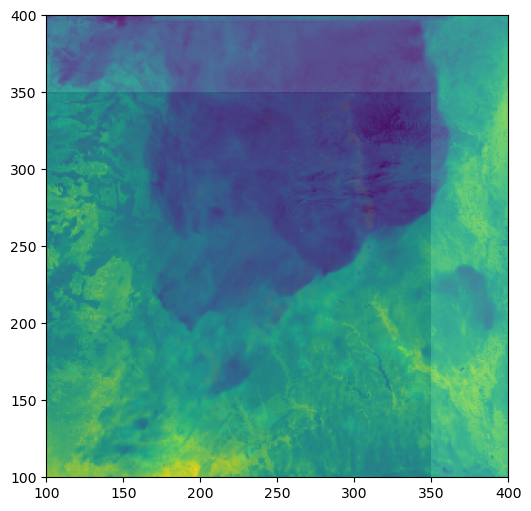

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def plot_image_stack(dataset, data_vars=['RAIN_AMOUNT', 'COMPOSITE_REFL_10CM', 'T2'], offset=50):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Loop through the images and plot each one with an offset
    for i, var in enumerate(data_vars):
        img = dataset.isel(time=-1)[var]
        extent = [i*offset, img.shape[1] + i*offset, i*offset, img.shape[0] + i*offset]
        ax.imshow(img, extent=extent, origin='lower', alpha=0.9)
    
    # Hide the axes
    #ax.axis('off')
    
    plt.show()

# Example usage
image_files = [
    'image1.png',  # Replace with your actual image paths
    'image2.png',
    'image3.png',
    'image4.png'
]

plot_image_stack(dataset)



## Creating the edge features between grid and mesh

In [8]:
spatial_features_kwargs = dict(
        add_node_positions=False,
        add_node_latitude=False,
        add_node_longitude=False,
        add_relative_positions=True,
        relative_longitude_local_coordinates=True,
        relative_latitude_local_coordinates=True,
    )

# Edges sending info from grid to mesh.
senders = grid_indices
receivers = mesh_indices

print(f'{senders.shape=}, {receivers.shape=}')

# Initialize lat and lon for the grid.
grid_nodes_lon, grid_nodes_lat = np.meshgrid(grid_lon, grid_lat)
grid_nodes_lon = grid_nodes_lon.reshape([-1]).astype(np.float32)
grid_nodes_lat = grid_nodes_lat.reshape([-1]).astype(np.float32)

# Precompute structural node and edge features according to config options.
# Structural features are those that depend on the fixed values of the
# latitude and longitudes of the nodes.
(senders_node_features, receivers_node_features,
     edge_features) = model_utils.get_bipartite_graph_spatial_features(
         senders_node_lat=grid_nodes_lat,
         senders_node_lon=grid_nodes_lon,
         receivers_node_lat=mesh_nodes_lat,
         receivers_node_lon=mesh_nodes_lon,
         senders=senders,
         receivers=receivers,
         edge_normalization_factor=None,
         **spatial_features_kwargs,
     )

# senders.shape=(657269,), receivers.shape=(657269,) for tiled mesh; not right! 
# senders.shape=(164790,), receivers.shape=(164790,)

senders.shape=(44245,), receivers.shape=(44245,)


In [18]:
657269 / 164790

3.9885247891255537

In [9]:
grid_nodes_lat.shape, mesh_nodes_lat.shape, mesh_nodes_lon.shape

((90000,), (8452,), (8452,))

In [10]:
senders_node_features.shape, receivers_node_features.shape, edge_features.shape

((90000, 0), (8452, 0), (657269, 4))

## Connecting Mesh to other Mesh nodes

In [9]:
# Work simply on the mesh edges.
mesh_senders, mesh_receivers = square_mesh.faces_to_edges(merged_meshes.faces)

print(f'{mesh_senders.shape=}, {mesh_receivers.shape=}')
print(f'{mesh_nodes_lon.shape=}, {mesh_nodes_lat.shape=}')

# Precompute structural node and edge features according to config options.
# Structural features are those that depend on the fixed values of the
# latitude and longitudes of the nodes.
node_features, edge_features = model_utils.get_graph_spatial_features(
        node_lat=mesh_nodes_lat,
        node_lon=mesh_nodes_lon,
        senders=mesh_senders,
        receivers=mesh_receivers,
        **spatial_features_kwargs,
    )

#mesh_senders.shape=(16380,), mesh_receivers.shape=(16380,) 
#mesh_nodes_lon.shape=(2113,), mesh_nodes_lat.shape=(2113,)
#rotation_matrices.shape=(2113, 3, 3), receivers.shape=(16380,)


mesh_senders.shape=(4080,), mesh_receivers.shape=(4080,)
mesh_nodes_lon.shape=(580,), mesh_nodes_lat.shape=(580,)
rotation_matrices.shape=(580, 3, 3), receivers.shape=(4080,)


In [17]:
16380 * 4

65520

## Connecting the Mesh nodes back to the grid points

In [18]:
# Create some edges according to how the grid nodes are contained by
# mesh triangles.
(these_grid_indices,
     these_mesh_indices) = square_mesh.in_mesh_triangle_indices(
         grid_size=N,
         mesh=finest_mesh)

In [ ]:
size = 300
plot_connectivity(size, finest_mesh, these_grid_indices, these_mesh_indices)

## Plotting the Mesh nodes on the WoFS domain. 

In [ ]:
# Plot the MESH Nodes on the WoFS Domain 

# Create a figure and axis with a geographic projection
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines for context
ax.coastlines()

data_to_plot = dataset['T'].isel(time=0, level=0)

# Plot the data
data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(),  # Ensures data is projected correctly
                  x='lon', y='lat',  # Specifies the coordinate variables
                  cbar_kwargs={'shrink': 0.5})  # Adjust the colorbar size

ax.scatter(x=mesh_nodes_lon, y=mesh_nodes_lat, transform=ccrs.PlateCarree(), s=1, color='red')

# Add a gridlines and set the extent if needed
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
lon_min, lon_max = dataset['lon'].min().values, dataset['lon'].max().values
lat_min, lat_max = dataset['lat'].min().values, dataset['lat'].max().values

#ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  